This notebook replicates the results of the paper [Conformal Prediction Under Covariate Shift (Tibshirani et al., 2020)](https://arxiv.org/pdf/1904.06019.pd).

In [1]:
from __future__ import annotations

from copy import deepcopy

from collections import defaultdict

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from mapie._typing import ArrayLike
from mapie.regression import MapieRegressor
from mapie.covariate_shift_regression import MapieCovShiftRegressor
from mapie.density_ratio import ProbClassificationDRE
from mapie.metrics import regression_coverage_score
from mapie.conformity_scores import (
    AbsoluteConformityScore, CovariateShiftConformityScore, ConformityScore
)
%load_ext autoreload
%autoreload 2
%matplotlib inline

palette = sns.color_palette("colorblind")
sns.set_theme(style="whitegrid", palette=palette, font_scale=1.3)

# Experiment Config

In [2]:
NTRIALS = 5000 # Number of times to repeat experiment
SEED = 2022 # Random seed
ALPHA = 0.1 # Targeted marginal coverage 
TEST_PROP = 0.5 # Proportion of all data to use as test set
CAL_PROP = 0.5 # Proportion of training data to use for conformal calibration

# Read Data

In [3]:
airfoil = pd.read_csv(
    "https://raw.githubusercontent.com/ryantibs/conformal/master/tibshirani2019/airfoil.txt",
    sep='\t', header=None)
airfoil.columns = ["Frequency", "Angle", "Chord", "Velocity", "Suction", "Sound"]
airfoil['Frequency'] = np.log(airfoil['Frequency'])
airfoil['Suction'] = np.log(airfoil['Suction'])
print(airfoil.shape)
airfoil.head()

(1503, 6)


,Frequency,Angle,Chord,Velocity,Suction,Sound
0,6.684612,0.0,0.3048,71.3,-5.928163,126.201
1,6.907755,0.0,0.3048,71.3,-5.928163,125.201
2,7.130899,0.0,0.3048,71.3,-5.928163,125.951
3,7.377759,0.0,0.3048,71.3,-5.928163,127.591
4,7.600902,0.0,0.3048,71.3,-5.928163,127.461


# Utilities for experiment

In [4]:
def get_X_y(data):
    return data.values[:, :-1], data.values[:, -1]


class OracleDRE():
    def __init__(self, beta: ArrayLike) -> None:
        self.beta = beta
    
    def fit(self) -> OracleDRE:
        return self
    
    def predict(self, X: ArrayLike) -> ArrayLike:
        return np.exp(X @ self.beta)
    
    def check_is_fitted(self) -> bool:
        return True

# Run experiment

## First check

In [5]:
# Oracle density ratios
oracle_dr_estimator = OracleDRE(beta=np.array([-1, 0, 0, 0, 1]))
oracle_dr = oracle_dr_estimator.predict(get_X_y(airfoil)[0]) 

In [6]:
# Partition into train and test data
train_data, test_data, _, test_oracle_dr = train_test_split(
    airfoil, oracle_dr, test_size=TEST_PROP, random_state=1
)
print(train_data.shape, test_data.shape, test_oracle_dr.shape)

# Construct shifted data
shift_data = test_data.sample(frac=0.25, replace=True, weights=test_oracle_dr)
print(shift_data.shape)

# Split into arrays of features and labels
X_train, y_train = get_X_y(train_data)
X_test, y_test = get_X_y(test_data)
X_shift, y_shift = get_X_y(shift_data)

# Split train into fit and cal set
X_fit, X_cal, y_fit, y_cal = train_test_split(
    X_train, y_train, test_size=CAL_PROP, random_state=1
)
# 4 datasets :
# - X_fit -> dataset used for training the base model
# - X_cal -> dataset used for calibrating the conformity scores
# - X_test -> dataset used for testing the uncertainties
# - X_shift -> shifted version of the test dataset
print(X_fit.shape, X_cal.shape, X_test.shape, X_shift.shape)

# Fit model to estimate E[Y|X]
model = LinearRegression(fit_intercept=True)
model.fit(X_fit, y_fit)

(751, 6) (752, 6) (752,)
(188, 6)
(375, 5) (376, 5) (752, 5) (188, 5)


LinearRegression()

In [32]:
# Fit covariate shift conformal w/ estimated weights
logreg_dr_estimator = ProbClassificationDRE(
    estimator=LogisticRegression(class_weight="balanced", max_iter=1000),
    clip_min=0.01,
    clip_max=0.99
)
logreg_dr_estimator.fit(X_train, X_test, source_prob=0.5, target_prob=0.5)
logreg_dr_estimator.calib_dr_estimates_ = logreg_dr_estimator.predict(X_cal)
covshift_score = CovariateShiftConformityScore(
    density_ratio_estimator=logreg_dr_estimator
)
covshift_logreg_conf = MapieRegressor(
    estimator=model, conformity_score=covshift_score, method="base", cv="prefit")
covshift_logreg_conf.fit(X_cal, y_cal)
y_pred_covshift, y_pis_covshift = covshift_logreg_conf.predict(X_test, alpha=0.1)

In [27]:
covshift_logreg_conf = MapieRegressor(
    estimator=model, conformity_score=covshift_score, method="base", cv="prefit")
covshift_logreg_conf.fit(X_cal, y_cal)
y_pred_covshift, y_pis_covshift = covshift_logreg_conf.predict(X_test, alpha=0.1)

In [28]:
mapie = MapieRegressor(
    estimator=model, method="base", cv="prefit")
mapie.fit(X_cal, y_cal)
y_pred, y_pis = mapie.predict(X_test, alpha=0.1)

In [30]:
print(
    (y_pis[:, 1, 0] - y_pis[:, 0, 0]).mean(),
    (y_pis_covshift[:, 1, 0] - y_pis_covshift[:, 0, 0]).mean()
)

15.605831533161277 15.605831533161277


In [12]:
print(
    regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0]),
    regression_coverage_score(y_test, y_pis_covshift[:, 0, 0], y_pis_covshift[:, 1, 0])
)

0.9002659574468085 0.9122340425531915


In [13]:
scores = np.stack([mapie.conformity_scores_ for _ in range(10)])
weights = np.random.uniform(0, 1, scores.shape) #np.ones(shape=scores.shape) / 5

In [14]:
from mapie.utils import weighted_quantile
weighted_quantile_ = weighted_quantile(scores, 0.9, 1, weights)

In [15]:
scores.min(), scores.max()

(0.012213975667265231, 14.560134682776564)

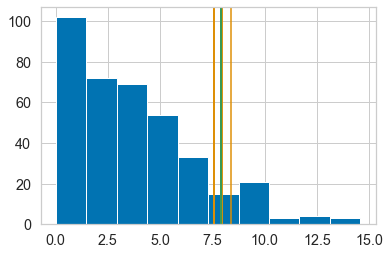

In [17]:
plt.hist(scores[0, :])
for i in range(10):
    plt.axvline(weighted_quantile_[i, 0], color="C1")
plt.axvline(np.quantile(scores, 0.9), color="C2")

## Experiment

In [18]:
# Make experiment reproducible
np.random.seed(SEED)

# Track results
results = []

# Repeat the experiment NTRIALS times
for trial_num in tqdm(range(NTRIALS)):
    
    # Partition into train and test data
    train_data, test_data, _, test_oracle_dr = train_test_split(
        airfoil, oracle_dr, test_size=TEST_PROP, random_state=trial_num
    )
    
    # Construct shifted data
    shift_data = test_data.sample(frac=0.25, replace=True, weights=test_oracle_dr)
    
    # Split into arrays of features and labels
    X_train, y_train = get_X_y(train_data)
    X_test, y_test = get_X_y(test_data)
    X_shift, y_shift = get_X_y(shift_data)
        
    # Split train into fit and cal set
    X_fit, X_cal, y_fit, y_cal = train_test_split(
        X_train, y_train, test_size=CAL_PROP, random_state=trial_num
    )
    # 4 datasets :
    # - X_fit -> dataset used for training the base model
    # - X_cal -> dataset used for calibrating the conformity scores
    # - X_test -> dataset used for testing the uncertainties
    # - X_shift -> shifted version of the test dataset
    # print(X_fit.shape, X_cal.shape, X_test.shape, X_shift.shape)
    
    # Fit model to estimate E[Y|X]
    model = LinearRegression(fit_intercept=True)
    model.fit(X_fit, y_fit)
    
    # Fit naive conformal
    naive_conf = MapieRegressor(estimator=model, method="base", cv="prefit")
    naive_conf.fit(X_cal, y_cal)
    
    for dist_type, test_features, test_labels in [
        ("In", X_test, y_test), ("Out", X_shift, y_shift)
    ]:
        
        if dist_type == "In":
            oracle_dr_estimator = OracleDRE(beta=np.array([0, 0, 0, 0, 0]))
        elif dist_type == "Out":
            oracle_dr_estimator = OracleDRE(beta=np.array([-1, 0, 0, 0, 1]))
        oracle_dr_estimator.residuals_dre_ = oracle_dr_estimator.predict(X_cal)
            
        # Fit covariate shift conformal w/ oracle weights
        covshift_oracle_score = CovariateShiftConformityScore(
            density_ratio_estimator=oracle_dr_estimator
        )
        covshift_oracle_conf = MapieRegressor(
            estimator=model, conformity_score=covshift_oracle_score, method="base", cv="prefit")
        covshift_oracle_conf.fit(X_cal, y_cal)

        # Fit covariate shift conformal w/ estimated weights
        logreg_dr_estimator = ProbClassificationDRE(
            estimator=LogisticRegression(class_weight="balanced", max_iter=1000),
            clip_min=0.01,
            clip_max=0.99
        )
        logreg_dr_estimator.fit(X_train, test_features, source_prob=0.5, target_prob=0.5)
        logreg_dr_estimator.residuals_dre_ = logreg_dr_estimator.predict(X_cal)
        covshift_lr_score = CovariateShiftConformityScore(
            density_ratio_estimator=logreg_dr_estimator
        )
        covshift_logreg_conf = MapieRegressor(
            estimator=model, conformity_score=covshift_lr_score, method="base", cv="prefit")
        covshift_logreg_conf.fit(X_cal, y_cal)

        rf_dr_estimator = ProbClassificationDRE(
            estimator=RandomForestClassifier(
                n_estimators=500,
                random_state=SEED, 
                max_depth=4,
                class_weight="balanced"
            ),
            clip_min=0.01,
            clip_max=0.99
        )
        rf_dr_estimator.fit(X_train, test_features, source_prob=0.5, target_prob=0.5)
        rf_dr_estimator.residuals_dre_ = rf_dr_estimator.predict(X_cal)
        covshift_rf_score = CovariateShiftConformityScore(
            density_ratio_estimator=logreg_dr_estimator
        )
        covshift_rf_conf = MapieRegressor(
            estimator=model, conformity_score=covshift_rf_score, method="base", cv="prefit")
        covshift_rf_conf.fit(X_cal, y_cal)

        # Predict and calculate metrics
        for name, conf_method in [
            ("Naive", naive_conf), 
            ("Weighted Oracle", covshift_oracle_conf), 
            ("Weighted Logistic Regression", covshift_logreg_conf), 
            ("Weighted Random Forest", covshift_rf_conf)
        ]:
            point_pred, set_pred = conf_method.predict(test_features, alpha=ALPHA)
            results.append({
                "Trial #": trial_num, 
                "Distribution": dist_type, 
                "Conformal Method": name, 
                "Marginal Coverage": regression_coverage_score(
                    test_labels, set_pred[:, 0], set_pred[:, 1]
                ),
                "Width": np.median(set_pred[:, 1] - set_pred[:, 0])
            })
            
results = pd.DataFrame(results)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:41:13<00:00,  1.21s/it]


In [19]:
results

,Trial #,Distribution,Conformal Method,Marginal Coverage,Width
0,0,In,Naive,0.902926,16.129158
1,0,In,Weighted Oracle,0.906915,16.202551
2,0,In,Weighted Logistic Regression,0.906915,16.202551
3,0,In,Weighted Random Forest,0.906915,16.202551
4,0,Out,Naive,0.750000,16.129158
...,...,...,...,...,...
39995,4999,In,Weighted Random Forest,0.885638,15.605832
39996,4999,Out,Naive,0.835106,15.605832
39997,4999,Out,Weighted Oracle,0.893617,19.323468
39998,4999,Out,Weighted Logistic Regression,0.893617,19.323468


# Visualize results

## 1. Naive conformal

### A. Marginal Coverage

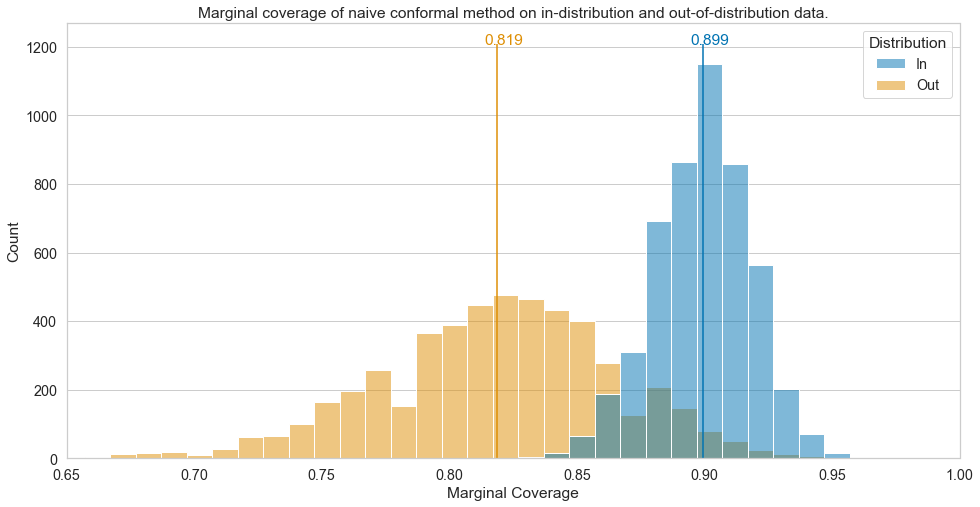

In [20]:
naive_results = results[results["Conformal Method"] == "Naive"]
mean_mc = naive_results.\
    groupby("Distribution")["Marginal Coverage"].\
    agg("mean")

fig, ax = plt.subplots(figsize=(16, 8))

g = sns.histplot(data=naive_results, x="Marginal Coverage",
                 hue="Distribution", ax=ax, binwidth=0.01)

ymin, ymax = ax.get_ylim()
for i, (k, v) in enumerate(mean_mc.iteritems()):
    ax.vlines(v, ymin, ymax, color=palette[i])
    ax.annotate(f"{v:.3f}", (v-0.005, ymax+0.5), color=palette[i])
    
ax.grid(False, axis="x")
ax.set_xlim((0.65, 1))
ax.set_title("Marginal coverage of naive conformal method on "\
             "in-distribution and out-of-distribution data.");

### B. Average length of prediction sets

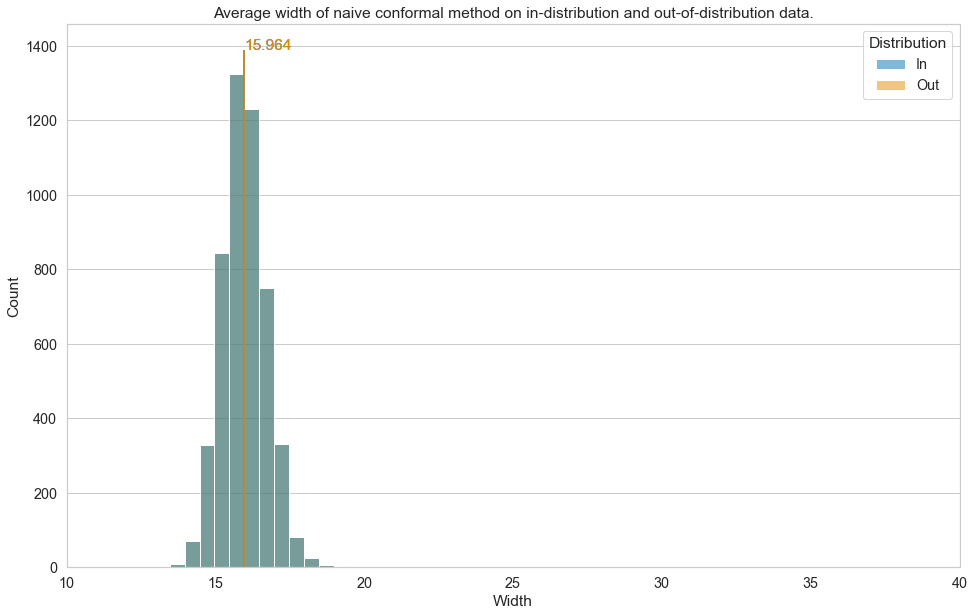

In [21]:
mean_width = naive_results.groupby("Distribution")["Width"].agg("mean")

fig, ax = plt.subplots(figsize=(16, 10))

g = sns.histplot(data=naive_results, x="Width", hue="Distribution", 
                 ax=ax, binwidth=0.5)

ymin, ymax = ax.get_ylim()
for i, (k, v) in enumerate(mean_width.iteritems()):
    ax.vlines(v, ymin, ymax, color=palette[i])
    ax.annotate(f"{v:.3f}", (v-0.005, ymax+0.5), color=palette[i])
    
ax.grid(False, axis="x")
ax.set_xlim((10, 40))
ax.set_title("Average width of naive conformal method on in-distribution "\
             "and out-of-distribution data.");

## 2. Weighted conformal 

### A. Marginal Coverage 

In [22]:
def mean_line(data, metric_name, color):
    ax = plt.gca()
    metric_mean = data.groupby("Distribution")[metric_name].agg("mean")
    for i, (k, v) in enumerate(metric_mean.iteritems()):
        ax.axvline(v, color=palette[i])    

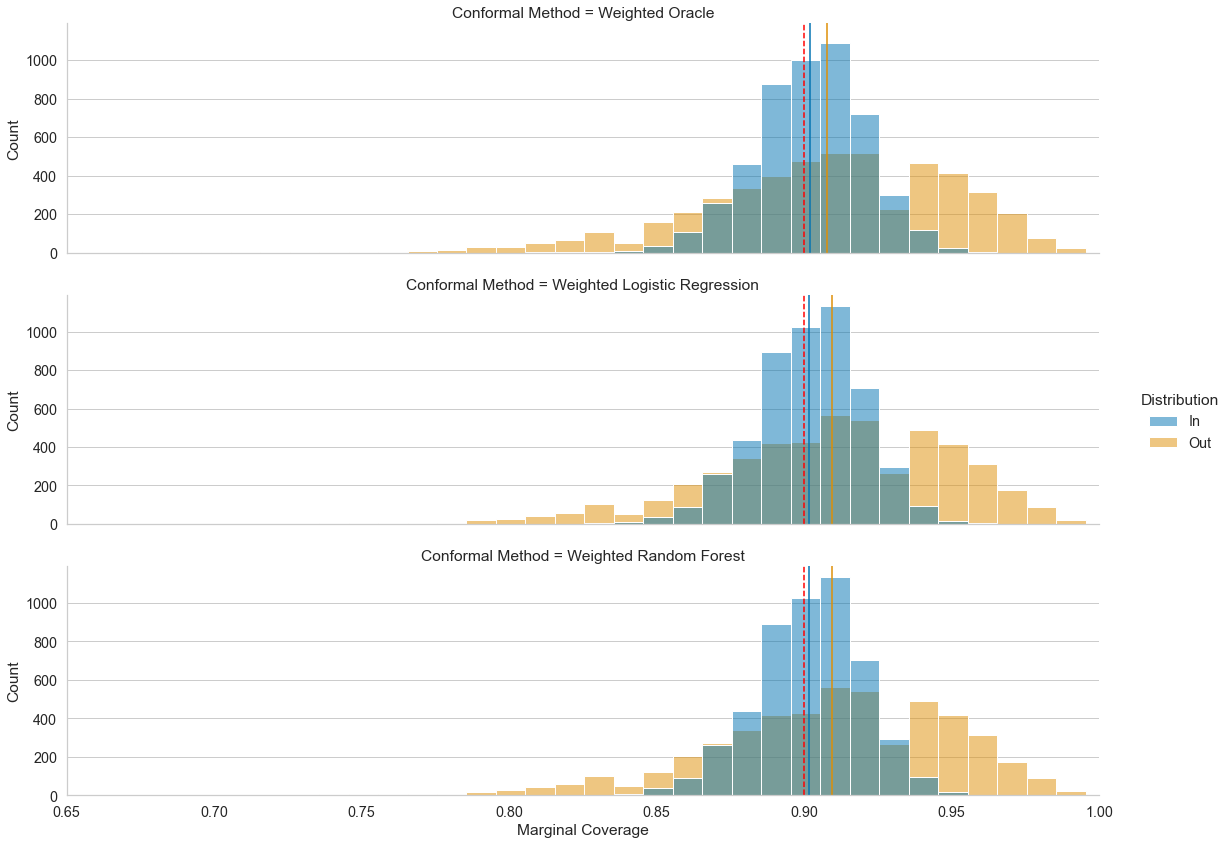

In [23]:
g = sns.displot(data=results[(results["Conformal Method"] != "Naive")],
                row="Conformal Method", x="Marginal Coverage", 
                hue="Distribution", height=4, aspect=4, binwidth=0.01)
g.map_dataframe(mean_line, metric_name="Marginal Coverage")
g.map(lambda **kwargs: plt.gca().grid(False, axis="x"))
g.set(xlim=(0.65, 1), 
      title="Marginal coverage of weighted conformal methods on "\
            "in-distribution and out-of-distribution data.")
g.refline(x=1-ALPHA, color="red")

### B. Average length of prediction sets

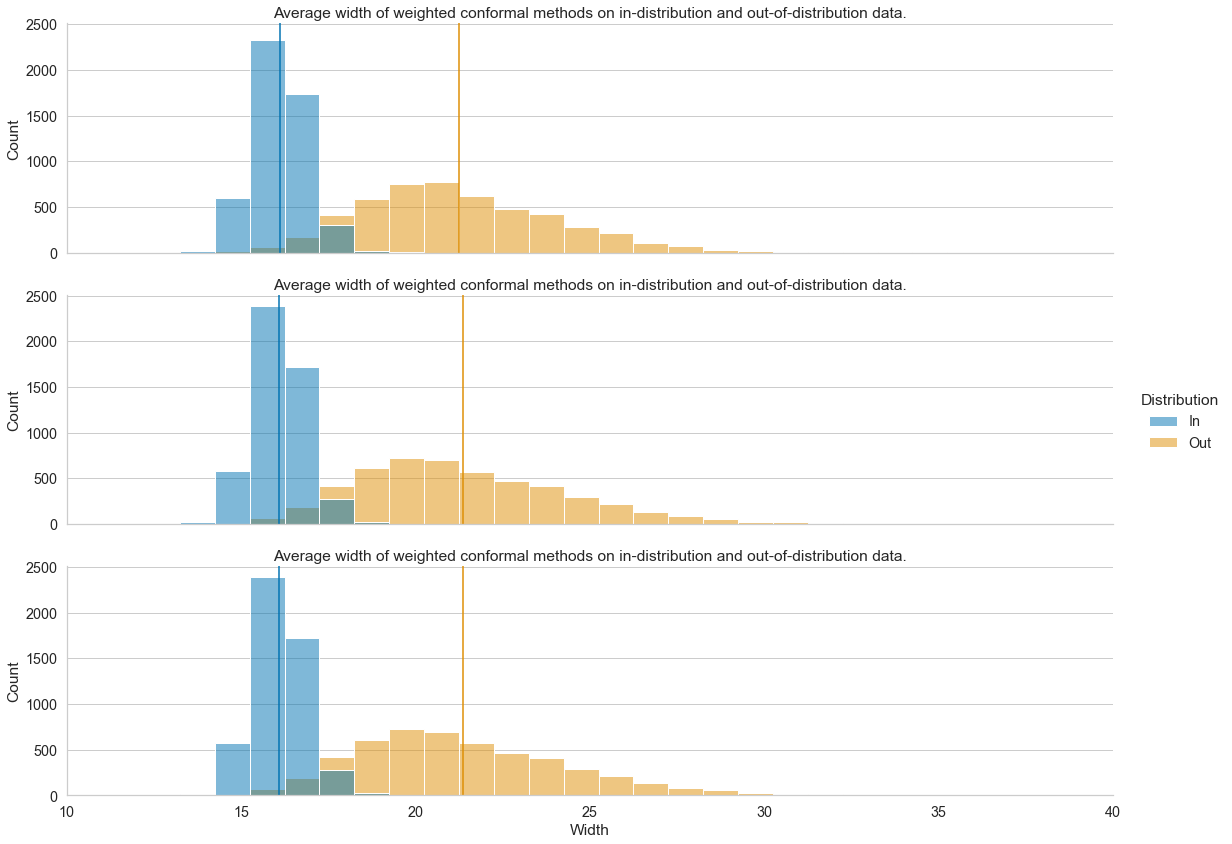

In [24]:
g = sns.displot(data=results[(results["Conformal Method"] != "Naive")],
                row="Conformal Method", x="Width", hue="Distribution", 
                height=4, aspect=4, binwidth=1)
g.map_dataframe(mean_line, metric_name="Width")
g.map(lambda **kwargs: plt.gca().grid(False, axis="x"))
g.set(xlim=(10, 40),
      title="Average width of weighted conformal methods on "\
            "in-distribution and out-of-distribution data.");